### Research Question


In [44]:
import pandas as pd
import numpy as np
import duckdb
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from sklearn.linear_model import LinearRegression, LogisticRegression

In [2]:
musicdata = pd.read_csv("data.csv")

In [3]:
musicdata.head()

,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,valence,year
0,0.995,['Carl Woitschach'],0.708,158648,0.1950,0,6KbQ3uYMLKb5jDxLF7wYDD,0.563,10,0.1510,-12.428,1,Singende Bataillone 1. Teil,0,1928,0.0506,118.469,0.7790,1928
1,0.994,"['Robert Schumann', 'Vladimir Horowitz']",0.379,282133,0.0135,0,6KuQTIu1KoTTkLXKrwlLPV,0.901,8,0.0763,-28.454,1,"Fantasiestücke, Op. 111: Più tosto lento",0,1928,0.0462,83.972,0.0767,1928
2,0.604,['Seweryn Goszczyński'],0.749,104300,0.2200,0,6L63VW0PibdM1HDSBoqnoM,0.000,5,0.1190,-19.924,0,Chapter 1.18 - Zamek kaniowski,0,1928,0.9290,107.177,0.8800,1928
3,0.995,['Francisco Canaro'],0.781,180760,0.1300,0,6M94FkXd15sOAOQYRnWPN8,0.887,1,0.1110,-14.734,0,Bebamos Juntos - Instrumental (Remasterizado),0,1928-09-25,0.0926,108.003,0.7200,1928
4,0.990,"['Frédéric Chopin', 'Vladimir Horowitz']",0.210,687733,0.2040,0,6N6tiFZ9vLTSOIxkj8qKrd,0.908,11,0.0980,-16.829,1,"Polonaise-Fantaisie in A-Flat Major, Op. 61",1,1928,0.0424,62.149,0.0693,1928


In [4]:
musicdata.shape

(169909, 19)

In [5]:
musicdata.tail()

,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,valence,year
169904,0.1730,"['DripReport', 'Tyga']",0.875,163800,0.443,1,4KppkflX7I3vJQk7urOJaS,0.000032,1,0.0891,-7.461,1,Skechers (feat. Tyga) - Remix,75,2020-05-15,0.1430,100.012,0.306,2020
169905,0.0167,"['Leon Bridges', 'Terrace Martin']",0.719,167468,0.385,0,1ehhGlTvjtHo2e4xJFB0SZ,0.031300,8,0.1110,-10.907,1,Sweeter (feat. Terrace Martin),64,2020-06-08,0.0403,128.000,0.270,2020
169906,0.5380,"['Kygo', 'Oh Wonder']",0.514,180700,0.539,0,52eycxprLhK3lPcRLbQiVk,0.002330,7,0.1080,-9.332,1,How Would I Know,70,2020-05-29,0.1050,123.700,0.153,2020
169907,0.0714,"['Cash Cash', 'Andy Grammer']",0.646,167308,0.761,0,3wYOGJYD31sLRmBgCvWxa4,0.000000,1,0.2220,-2.557,1,I Found You,70,2020-02-28,0.0385,129.916,0.472,2020
169908,0.1090,['Ingrid Andress'],0.512,214787,0.428,0,60RFlt48hm0l4Fu0JoccOl,0.000000,0,0.1050,-7.387,1,More Hearts Than Mine,65,2020-03-27,0.0271,80.588,0.366,2020


In [6]:
econdata= pd.read_csv("index.csv")

In [7]:
econdata.head()

,Year,Month,Day,Federal Funds Target Rate,Federal Funds Upper Target,Federal Funds Lower Target,Effective Federal Funds Rate,Real GDP (Percent Change),Unemployment Rate,Inflation Rate
0,1954,7,1,NaN,NaN,NaN,0.80,4.6,5.8,NaN
1,1954,8,1,NaN,NaN,NaN,1.22,NaN,6.0,NaN
2,1954,9,1,NaN,NaN,NaN,1.06,NaN,6.1,NaN
3,1954,10,1,NaN,NaN,NaN,0.85,8.0,5.7,NaN
4,1954,11,1,NaN,NaN,NaN,0.83,NaN,5.3,NaN


In [59]:
cleandata= musicdata[["danceability","year", "valence"]]

In [60]:
cleandata

,danceability,year,valence
0,0.708,1928,0.7790
1,0.379,1928,0.0767
2,0.749,1928,0.8800
3,0.781,1928,0.7200
4,0.210,1928,0.0693
...,...,...,...
169904,0.875,2020,0.3060
169905,0.719,2020,0.2700
169906,0.514,2020,0.1530
169907,0.646,2020,0.4720


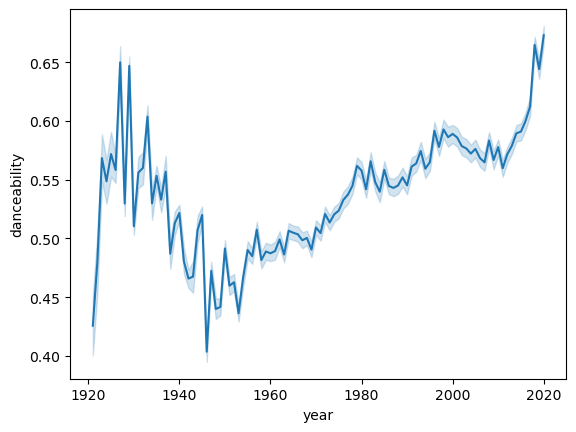

In [62]:
graph = sns.lineplot(cleandata, x= "year", y= "danceability")

In [63]:
interestdata= pd.read_csv("interest.csv")

In [64]:
interestdata.head(15)

,DATE,UNRATE
0,1948-01-01,3.4
1,1948-02-01,3.8
2,1948-03-01,4.0
3,1948-04-01,3.9
4,1948-05-01,3.5
5,1948-06-01,3.6
6,1948-07-01,3.6
7,1948-08-01,3.9
8,1948-09-01,3.8
9,1948-10-01,3.7


In [65]:
interestdata["DATE"].dtype

dtype('O')

In [66]:
interestdata['DATE']= pd.to_datetime(interestdata['DATE'], format='%Y-%m-%d', errors='coerce')
interestdata

,DATE,UNRATE
0,1948-01-01,3.4
1,1948-02-01,3.8
2,1948-03-01,4.0
3,1948-04-01,3.9
4,1948-05-01,3.5
...,...,...
916,2024-05-01,4.0
917,2024-06-01,4.1
918,2024-07-01,4.3
919,2024-08-01,4.2


In [67]:
interestrate_year = duckdb.sql("SELECT year(DATE) AS Year, AVG(UNRATE) AS InterestRate FROM interestdata GROUP BY year(DATE)").df()
interestrate_year

,Year,InterestRate
0,1948,3.750000
1,1949,6.050000
2,1950,5.208333
3,1951,3.283333
4,1952,3.025000
...,...,...
72,2021,5.350000
73,2022,3.633333
74,2023,3.625000
75,2024,4.000000


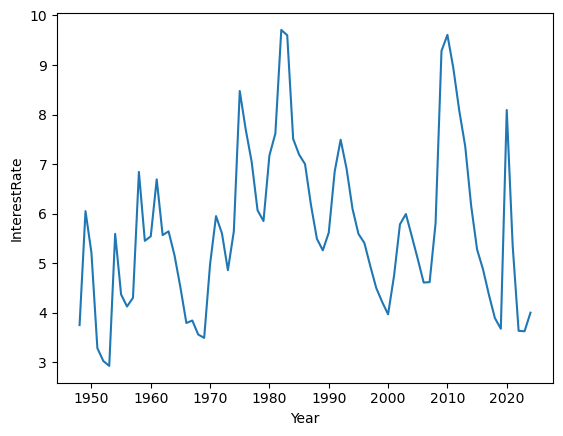

In [68]:
graph = sns.lineplot(interestrate_year, x= "Year", y= "InterestRate")

In [35]:
dance_interest= duckdb.sql("SELECT interestrate_year.Year,\
        danceability, InterestRate FROM interestrate_year INNER JOIN \
        musicdata ON interestrate_year.Year = musicdata.year").df()
dance_interest

,Year,danceability,InterestRate
0,1971,0.330,5.95
1,1971,0.652,5.95
2,1971,0.266,5.95
3,1971,0.239,5.95
4,1971,0.349,5.95
...,...,...,...
145469,1971,0.492,5.95
145470,1971,0.572,5.95
145471,1971,0.709,5.95
145472,1971,0.640,5.95


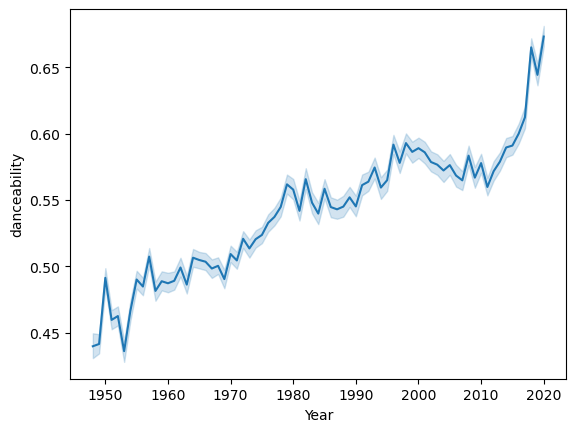

In [41]:
dangraph = sns.lineplot(dance_interest, x= "Year", y= "danceability")


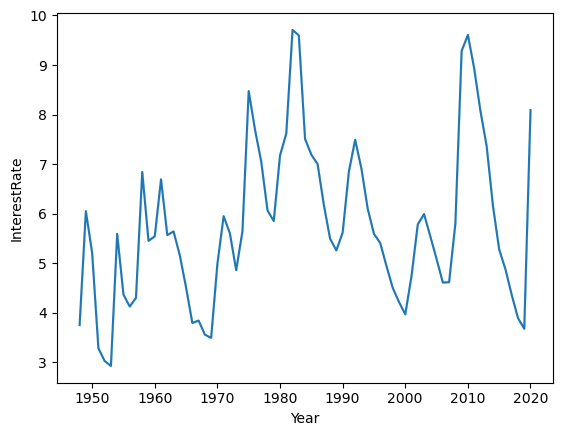

In [42]:
interestgraph = sns.lineplot(dance_interest, x= "Year", y= "InterestRate")

In [43]:
dance_interest.corr()

,Year,danceability,InterestRate
Year,1.000000,0.260207,0.269437
danceability,0.260207,1.000000,0.069244
InterestRate,0.269437,0.069244,1.000000


In [56]:
X=dance_interest['InterestRate']
X= X.values.reshape(-1,1)
y=dance_interest['danceability']
lin_model = LinearRegression().fit(X,y)
print(lin_model.coef_)

[0.00750481]


In [73]:
valencedata= cleandata[['year','valence']]

In [74]:
valence_interest= duckdb.sql("SELECT interestrate_year.Year,\
        valence, InterestRate FROM interestrate_year INNER JOIN \
        valencedata ON interestrate_year.Year = valencedata.year").df()
valence_interest

,Year,valence,InterestRate
0,1971,0.540,5.95
1,1971,0.921,5.95
2,1971,0.432,5.95
3,1971,0.292,5.95
4,1971,0.342,5.95
...,...,...,...
145469,1971,0.631,5.95
145470,1971,0.635,5.95
145471,1971,0.740,5.95
145472,1971,0.954,5.95


In [75]:
valence_interest.corr()

,Year,valence,InterestRate
Year,1.000000,-0.021090,0.269437
valence,-0.021090,1.000000,0.052381
InterestRate,0.269437,0.052381,1.000000


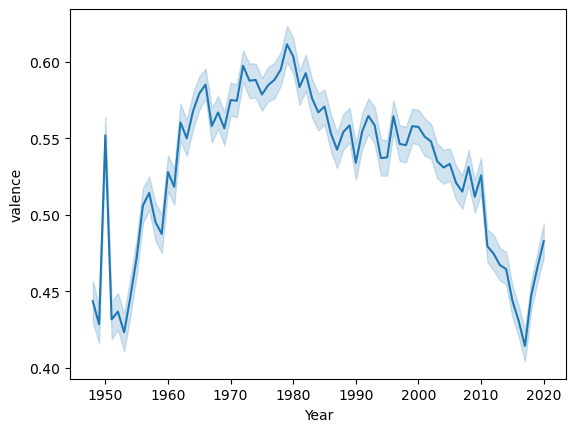

In [76]:
valencegraph = sns.lineplot(valence_interest, x= "Year", y= "valence")

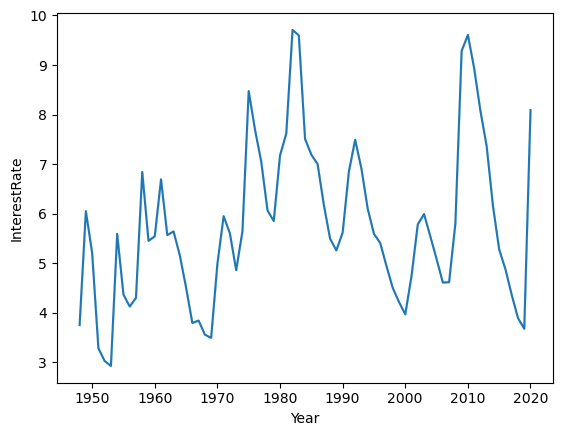

In [77]:
interestgraph = sns.lineplot(dance_interest, x= "Year", y= "InterestRate")

In [79]:
musicdata['popularity'].unique()

array([  0,   1,   2,   3,   7,   6,   5,   4,   8,  14,  13,  11,  10,
        12,   9,  15,  19,  17,  18,  16,  20,  24,  21,  23,  22,  25,
        42,  28,  27,  37,  36,  35,  30,  26,  29,  44,  32,  33,  31,
        41,  46,  34,  45,  40,  38,  39,  54,  48,  58,  52,  47,  43,
        49,  51,  56,  55,  50,  57,  59,  66,  53,  61,  60,  62,  64,
        65,  69,  72,  63,  70,  68,  67,  71,  74,  75,  78,  81,  77,
        73,  80,  76,  79,  82,  83,  85,  84,  91,  92,  87,  86,  89,
        95,  93,  88,  90,  94,  99,  96, 100,  97])

In [80]:
musicdata['popularity'].mean()

31.55660971461194

In [81]:
musicdata['popularity'].mode()

0    0
Name: popularity, dtype: int64

In [82]:
musicdata['popularity'].median()

33.0

In [97]:
number = duckdb.sql("SELECT COUNT(popularity), year, popularity FROM musicdata GROUP BY popularity,year HAVING popularity>=50").df()
number['popularity'].unique()
number

,count(popularity),year,popularity
0,31,1971,50
1,28,1971,51
2,12,1972,53
3,17,1972,51
4,15,1972,52
...,...,...,...
1877,2,1980,70
1878,4,1986,69
1879,6,1990,64
1880,8,1966,57


In [101]:
pop_dance_data=duckdb.sql("SELECT danceability, year, popularity FROM musicdata WHERE popularity>=50").df()
pop_dance_data

,danceability,year,popularity
0,0.596,1970,54
1,0.248,1973,58
2,0.523,1973,54
3,0.526,1973,52
4,0.594,1977,52
...,...,...,...
38476,0.875,2020,75
38477,0.719,2020,64
38478,0.514,2020,70
38479,0.646,2020,70


In [103]:
pop_data_interest= duckdb.sql("SELECT interestrate_year.Year,\
        danceability, InterestRate FROM interestrate_year INNER JOIN \
        pop_dance_data ON interestrate_year.Year = pop_dance_data.year").df()
pop_data_interest

,Year,danceability,InterestRate
0,1970,0.596,4.983333
1,1977,0.594,7.050000
2,1979,0.442,5.850000
3,1980,0.556,7.175000
4,1981,0.613,7.616667
...,...,...,...
38459,1991,0.500,6.850000
38460,1991,0.716,6.850000
38461,1991,0.968,6.850000
38462,1991,0.629,6.850000


In [104]:
pop_data_interest.corr()

,Year,danceability,InterestRate
Year,1.000000,0.132852,-0.047336
danceability,0.132852,1.000000,-0.039838
InterestRate,-0.047336,-0.039838,1.000000
